# Setup

In [1]:
#! git clone https://github.com/tensorflow/models

In [2]:
import sys
import os

os.environ["CUDA_VISIBLE_DEVICES"] = '0'
sys.path.append("./models/research")
sys.path.append("./models/research/slim")
sys.path.append("./models/research/object_detection")

In [3]:
import tensorflow as tf

gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=0.333)
sess = tf.Session(config=tf.ConfigProto(gpu_options=gpu_options))

In [4]:
from utils import label_map_util
from utils import visualization_utils as vis_util

# Load model

In [5]:
MODEL_NAME = 'ssd_mobilenet_v1_coco_11_06_2017'
MODEL_FILE = MODEL_NAME + '.tar.gz'
DOWNLOAD_BASE = 'http://download.tensorflow.org/models/object_detection/'

PATH_TO_CKPT = MODEL_NAME + '/frozen_inference_graph.pb'
PATH_TO_LABELS = './models/research/object_detection/data/mscoco_label_map.pbtxt'

NUM_CLASSES = 100

In [6]:
import six.moves.urllib as urllib
import tarfile

opener = urllib.request.URLopener()
opener.retrieve(DOWNLOAD_BASE + MODEL_FILE, MODEL_FILE)
tar_file = tarfile.open(MODEL_FILE)

for file in tar_file.getmembers():
    file_name = os.path.basename(file.name)
    if 'frozen_inference_graph.pb' in file_name:
        tar_file.extract(file, os.getcwd())

In [7]:
detection_graph = tf.Graph()
with detection_graph.as_default():
    od_graph_def = tf.GraphDef()
    with tf.gfile.GFile(PATH_TO_CKPT, 'rb') as fid:
        serialized_graph = fid.read()
        od_graph_def.ParseFromString(serialized_graph)
        tf.import_graph_def(od_graph_def, name='')

In [8]:
label_map = label_map_util.load_labelmap(PATH_TO_LABELS)
categories = label_map_util.convert_label_map_to_categories(label_map, max_num_classes=NUM_CLASSES, use_display_name=True)
category_index = label_map_util.create_category_index(categories)

In [9]:
import numpy as np

def load_image_into_numpy_array(image):
    (im_width, im_height) = image.size
    return np.array(image.getdata()).reshape((im_height, im_width, 3)).astype(np.uint8)

# Object detection

In [10]:
#! wget http://host.robots.ox.ac.uk/pascal/VOC/voc2012/VOCtrainval_11-May-2012.tar

In [11]:
#! tar -xvf VOCtrainval_11-May-2012.tar

In [12]:
validate = []
with open("./VOCdevkit/VOC2012/ImageSets/Main/val.txt") as file:
    validate = file.read().splitlines()

n_vis = 10    
VIS_IMAGE_PATHS = [os.path.join('./VOCdevkit/VOC2012/JPEGImages', validate[i] + ".jpg") for i in range(n_vis)]
IMAGE_SIZE = (12, 8)

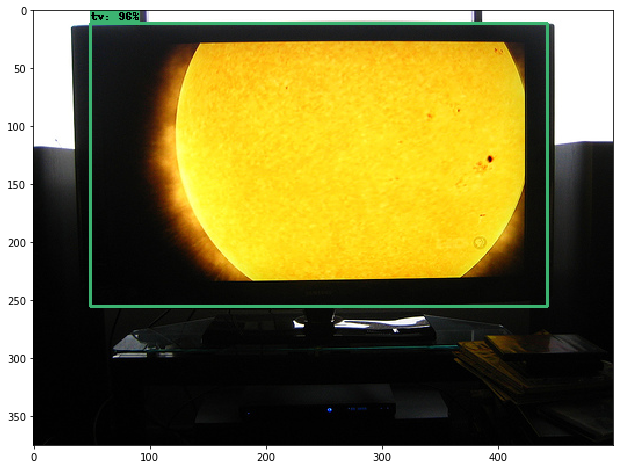

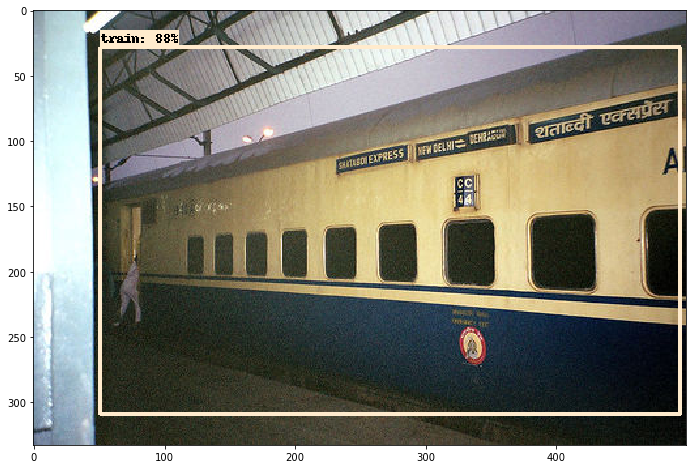

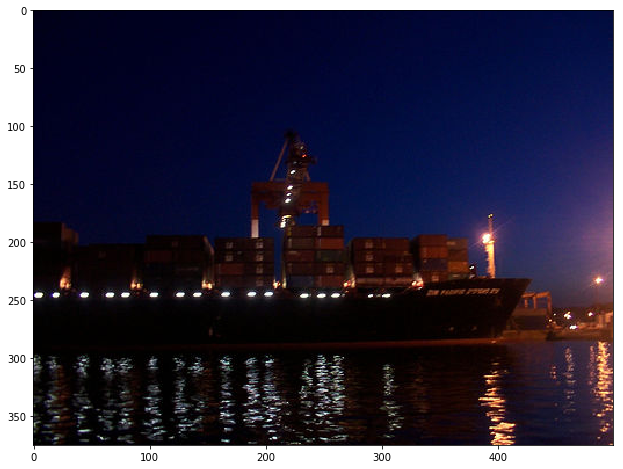

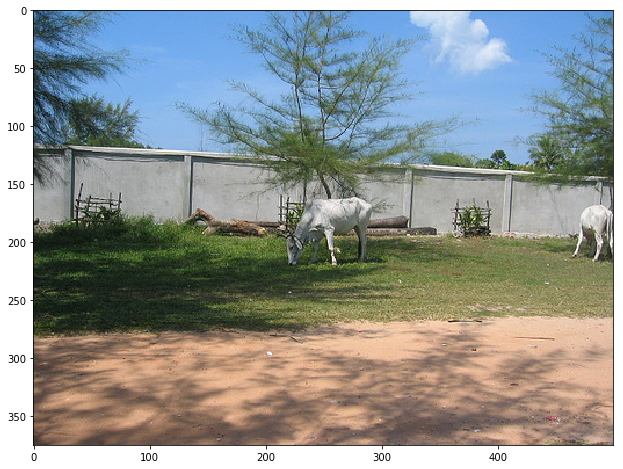

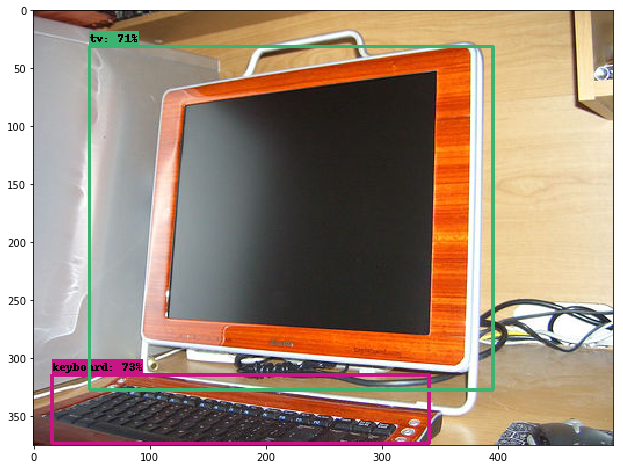

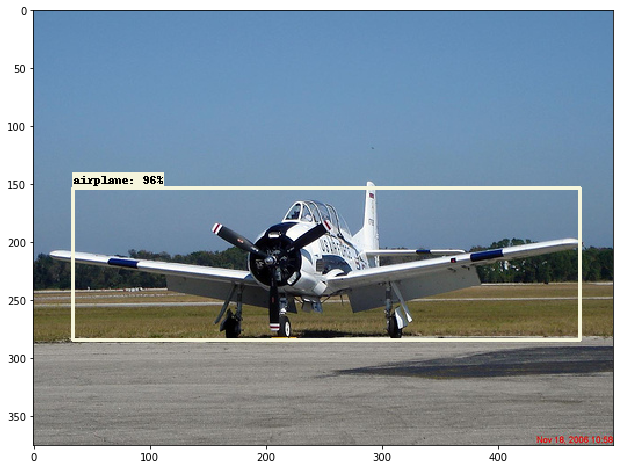

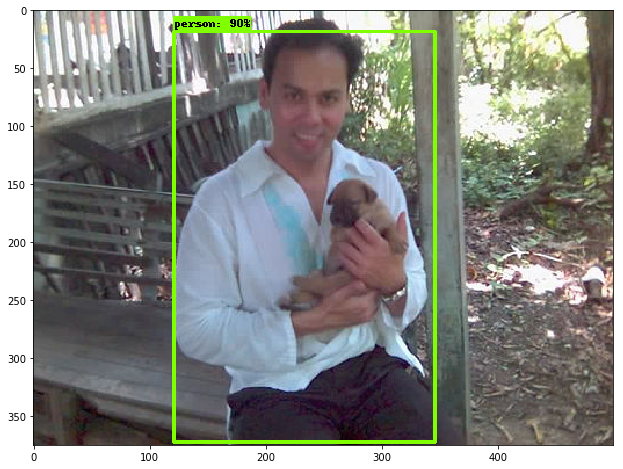

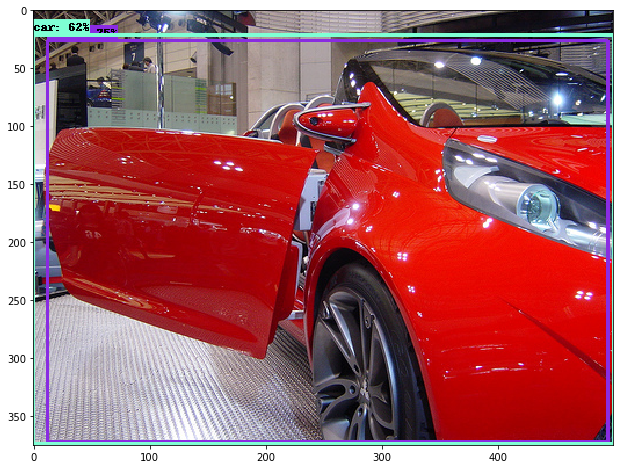

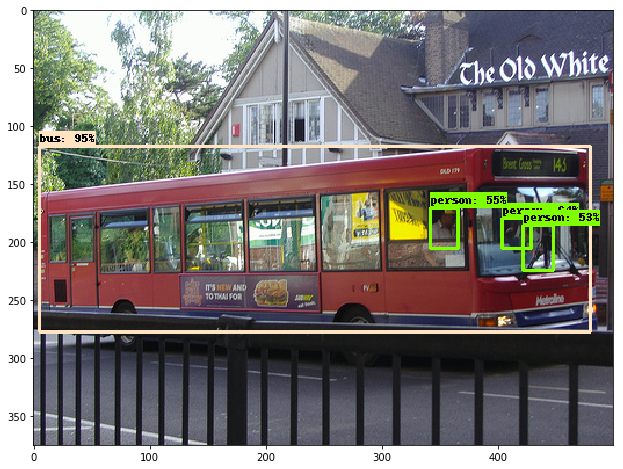

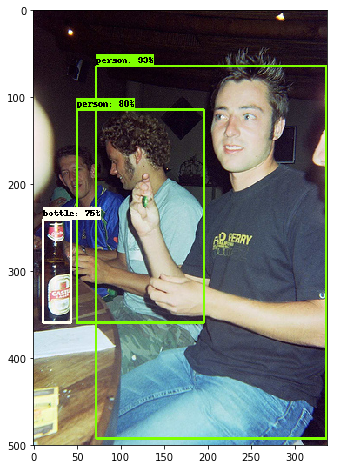

In [13]:
from PIL import Image
from matplotlib import pyplot as plt
%matplotlib inline

with detection_graph.as_default():
      with tf.Session(graph=detection_graph) as sess:
        image_tensor = detection_graph.get_tensor_by_name('image_tensor:0')
        detection_boxes = detection_graph.get_tensor_by_name('detection_boxes:0')
        detection_scores = detection_graph.get_tensor_by_name('detection_scores:0')
        detection_classes = detection_graph.get_tensor_by_name('detection_classes:0')
        num_detections = detection_graph.get_tensor_by_name('num_detections:0')
        
        for image_path in VIS_IMAGE_PATHS:
            image = Image.open(image_path)
            image_np = load_image_into_numpy_array(image)
            image_np_expanded = np.expand_dims(image_np, axis=0)
            (boxes, scores, classes, num) = sess.run(
              [detection_boxes, detection_scores, detection_classes, num_detections],
              feed_dict={image_tensor: image_np_expanded})
            
            vis_util.visualize_boxes_and_labels_on_image_array(
              image_np,
              np.squeeze(boxes),
              np.squeeze(classes).astype(np.int32),
                 np.squeeze(scores),
                 category_index,
                 use_normalized_coordinates=True,
                 line_thickness=3)
            plt.figure(figsize=IMAGE_SIZE)
            plt.imshow(image_np)

# Count metrics

In [14]:
import xml.etree.ElementTree as ET

PATH_TO_IMAGE_ANNOTATIONS = "./VOCdevkit/VOC2012/Annotations"
VALIDATE_IMAGE_ANNOTATIONS = [ET.parse(os.path.join(PATH_TO_IMAGE_ANNOTATIONS, "{}.xml".format(image))).getroot() for image in validate]

In [15]:
from collections import namedtuple

BB = namedtuple("BB", "xmin ymin xmax ymax")
Obj = namedtuple("Obj", "name bb")

In [16]:
def get_bb(node):
    args = {child.tag: child.text for child in node}
    return BB(float(args["xmin"]), float(args["ymin"]), float(args["xmax"]), float(args["ymax"]))
    
def get_obj(node):
    objs = []
    for child in node:
        if child.tag == "object":
            args = {grandchild.tag: grandchild for grandchild in child}
            objs.append(Obj(args["name"].text, get_bb(args["bndbox"])))
    return objs

In [17]:
PATH_TO_TEST_IMAGES_DIR = "./VOCdevkit/VOC2012/JPEGImages"
VALIDATE_IMAGE_PATHS = [os.path.join(PATH_TO_TEST_IMAGES_DIR, "{}.jpg".format(image)) for image in validate]

In [18]:
valid_images = []
valid_annotations = []

category_id = {category["name"]: category["id"] for category in categories}

for (image, annotation) in zip(VALIDATE_IMAGE_PATHS, VALIDATE_IMAGE_ANNOTATIONS):
    objects = get_obj(annotation)
    names = np.unique(list(map(lambda it: it.name, objects)))
    if len(names) and len(objects) == len(names) and all((name in category_id for name in names)):
        valid_images.append(image)
        valid_annotations.append(annotation)

In [19]:
len(valid_images)

2533

In [20]:
def accuracy(annotation, boxes, scores, classes):
    objects = get_obj(annotation)
    acc = []
    for obj in objects:
        indices = (classes == category_id[obj.name])
        acc.append(np.max(scores[indices]) > 0.5 if np.sum(indices) else 0)
    return np.mean(acc)

In [21]:
def get_intersection(box1, box2):
    dx = min(box1.xmax, box2.xmax) - max(box1.xmin, box2.xmin)
    dy = min(box1.ymax, box2.ymax) - max(box1.ymin, box2.ymin)
    return 0 if dx < 0 or dy < 0 else dx * dy

def get_square(box):
    return (box.xmax - box.xmin) * (box.ymax - box.ymin)

def get_iou(box1, box2):
    intersection = get_intersection(box1, box2)
    union = get_square(box1) + get_square(box2) - intersection
    return intersection / union
    
def IoU(annotation, boxes, scores, classes):
    objects = get_obj(annotation)
    iou = []
    for obj in objects:
        indices = (classes == category_id[obj.name])
        boxes_scaled = (BB(375.0 * box[0], 500.0 * box[1], 375.0 * box[2], 500.0 * box[3]) for box in boxes[indices])
        iou.append(max(0, np.max([get_iou(box, obj.bb) for box in boxes_scaled]) if np.sum(indices) else 0))      
    return np.mean(iou)

In [23]:
res_accuracy = []
res_IoU = []
    
with detection_graph.as_default():
    with tf.Session(graph=detection_graph) as sess:   
        image_tensor = detection_graph.get_tensor_by_name('image_tensor:0')
        detection_boxes = detection_graph.get_tensor_by_name('detection_boxes:0')
        detection_scores = detection_graph.get_tensor_by_name('detection_scores:0')
        detection_classes = detection_graph.get_tensor_by_name('detection_classes:0')
        num_detections = detection_graph.get_tensor_by_name('num_detections:0')
              
        for (image_path, annotation) in zip(valid_images, valid_annotations):
            image = Image.open(image_path)
            image_np = load_image_into_numpy_array(image)
            image_np_expanded = np.expand_dims(image_np, axis=0)
            
            (boxes, scores, classes, num) = sess.run(
                [detection_boxes, detection_scores, detection_classes, num_detections],
                feed_dict={image_tensor: image_np_expanded})
                
            res_accuracy.append(accuracy(annotation, boxes.squeeze(), scores.squeeze(), classes.squeeze()))
            res_IoU.append(IoU(annotation, boxes.squeeze(), scores.squeeze(), classes.squeeze()))       

In [24]:
def vis_stats(data):
    fig = plt.figure(1, figsize=(6, 6))
    ax = fig.add_subplot(111)
    ax.violinplot(data)
    print("mean = " + str(np.mean(data))) 

# Accuracy

mean = 0.753257007501


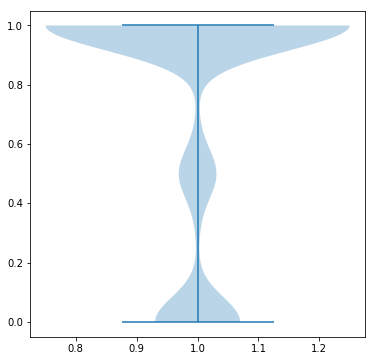

In [25]:
vis_stats(res_accuracy)

# IoU

mean = 0.439209263395


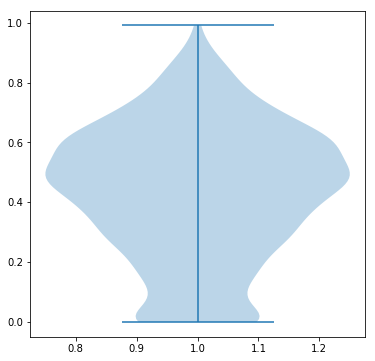

In [26]:
vis_stats(res_IoU)